In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

# 1. 가상의 암 진단 데이터 생성 (1000명 중 5%만 환자)
# weights=[0.95, 0.05] -> 95:5 비율 설정
X, y = make_classification(n_samples=1000, n_features=5, n_informative=3, n_redundant=0, n_clusters_per_class=1, weights=[0.95, 0.05], random_state=42)

df = pd.DataFrame(X, columns=['F1', 'F2', 'F3', 'F4', 'F5'])
df['Target_Cancer'] = y

print("=== 데이터 분포 확인 ===")
print(df['Target_Cancer'].value_counts())

=== 데이터 분포 확인 ===
Target_Cancer
0    943
1     57
Name: count, dtype: int64
         F1        F2        F3        F4        F5  Target_Cancer
0 -1.280456  0.351687  0.189480  2.113371 -1.638728              0
1 -1.371674 -0.232364 -0.709441  2.196052 -1.475681              0
2  1.748137  2.173455  1.040062  0.665090  1.379844              1
3  0.815501 -0.612540 -0.048089  1.051042 -1.080790              0
4 -0.104343  0.084289  0.393307  1.460208 -1.347255              0


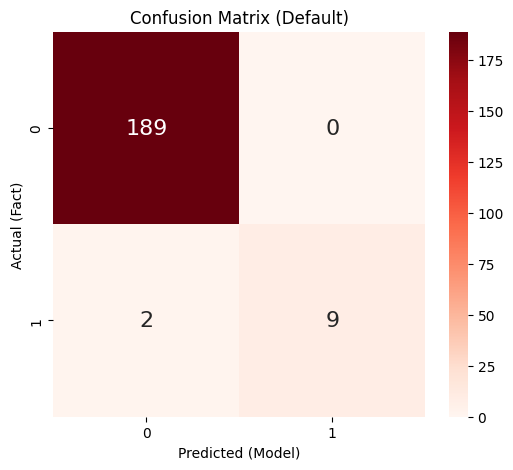


=== 분류 리포트 ===
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       189
           1       1.00      0.82      0.90        11

    accuracy                           0.99       200
   macro avg       0.99      0.91      0.95       200
weighted avg       0.99      0.99      0.99       200



In [ ]:
# 2. 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['Target_Cancer']), df['Target_Cancer'], test_size=0.2, random_state=42, stratify=df['Target_Cancer'])

# 3. 모델 학습
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# 4. 예측 및 평가
pred = model.predict(X_test)
cm = confusion_matrix(y_test, pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', annot_kws={"size": 16})
plt.title('Confusion Matrix (Default)')
plt.xlabel('Predicted (Model)')
plt.ylabel('Actual (Fact)')
plt.show()

print("\n=== 분류 리포트 ===")
print(classification_report(y_test, pred))

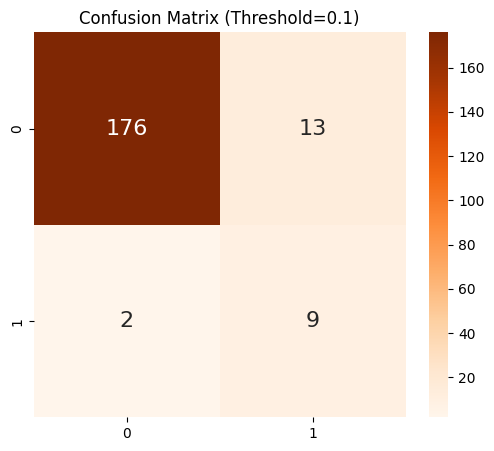


=== 분류 리포트 (임계값 0.1) ===
              precision    recall  f1-score   support

           0       0.99      0.93      0.96       189
           1       0.41      0.82      0.55        11

    accuracy                           0.93       200
   macro avg       0.70      0.87      0.75       200
weighted avg       0.96      0.93      0.94       200



In [4]:
# 5. 임계값(Threshold) 조정으로 재현율 올리기
# 모델이 예측한 '확률'을 가져옵니다. (0일 확률, 1일 확률)
proba = model.predict_proba(X_test)

# 암(1)일 확률이 10%만 넘어도 '암'이라고 판정! (기준 완화)
threshold = 0.1
new_pred = (proba[:, 1] >= threshold).astype(int)

new_cm = confusion_matrix(y_test, new_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(new_cm, annot=True, fmt='d', cmap='Oranges', annot_kws={"size": 16})
plt.title(f'Confusion Matrix (Threshold={threshold})')
plt.show()

print(f"\n=== 분류 리포트 (임계값 {threshold}) ===")
print(classification_report(y_test, new_pred))

날카로운 지적입니다\! \*\*FP(가짜 양성)\*\*가 늘어난 것은 맞지만, \*\*FN(가짜 음성)\*\*은 이론적으로 줄어들거나 그대로여야 합니다.

사용자님이 올려주신 두 이미지를 비교 분석해 드릴게요. 아주 중요한 **트레이드오프(Trade-off)** 관계를 발견하셨습니다.

-----

### 📊 이미지 데이터 비교 분석

**1. 기존 결과 (Default, Threshold=0.5)**

  * **FP (정상을 암이라 오진):** 0명 (아주 깨끗함)
  * **FN (암을 정상이라 놓침):** **2명** (위험\!)

**2. 변경된 결과 (Threshold=0.1)**

  * **FP (정상을 암이라 오진):** **13명** (0명 $\rightarrow$ 13명으로 **급증\!**)
  * **FN (암을 정상이라 놓침):** 2명 (2명 $\rightarrow$ 2명으로 **변화 없음**)

-----

### 💡 왜 이런 결과가 나왔을까요?

**1. FP(오진)가 늘어난 이유 (정상 $\rightarrow$ 증가)**

  * 맞습니다. 문턱(Threshold)을 0.5에서 0.1로 낮췄다는 건 **"조금이라도 의심스러우면 다 암환자로 분류해\!"** 라고 명령한 것과 같습니다.
  * 그러니 애매했던 **정상인 13명**이 "너 암일 수도 있어"라고 분류되어 **FP가 늘어난 것**입니다.

**2. FN(놓침)이 그대로인 이유 (이론상 감소해야 함)**

  * 원래 문턱을 낮추면 암환자를 더 잘 잡아내서 **FN이 줄어들어야 정상**입니다.
  * 그런데도 **FN이 2명 그대로**인 이유는, 모델이 이 2명의 암 환자를 \*\*"확률 10%(0.1) 미만의 아주 확실한 정상인"\*\*이라고 완전히 잘못 판단하고 있기 때문입니다. (예: 확률을 0.01로 예측함)
  * 이 경우 Threshold를 0.05 등으로 더 낮추지 않는 이상 FN은 줄지 않습니다.

-----

### ⚖️ 의료 AI의 핵심: "어떤 실수가 더 나쁜가?"

이 실습의 핵심은 \*\*"실수의 종류를 선택하는 것"\*\*입니다.

| 구분 | 상황 (암 진단) | 결과의 심각성 | 우리의 전략 |
| :-- | :-- | :-- | :-- |
| **FP (False Positive)** | 정상인에게 "암입니다" 함 | 재검사 비용 발생, 환자가 놀람 | **감수할 수 있음 (생명 지장 X)** |
| **FN (False Negative)** | **암 환자에게 "정상입니다" 함** | **치료 시기 놓침, 사망 위험** | **절대 막아야 함 (치명적)** |

**결론:**
사용자님의 결과에서 **FP가 늘어난 것은 의도된 결과**입니다. (정상인을 좀 귀찮게 하더라도 암 환자를 놓치지 않으려는 전략)
만약 FN이 여전히 2명이라면, 현업에서는 **Threshold를 0.01까지 더 낮추거나**, 모델 성능 자체를 더 올려야 합니다.

### 🚀 다음 단계 제안

"FN(놓친 환자)을 0으로 만들 때까지 문턱을 낮춰볼까요?"

```python
# Threshold를 0.05 (5%)까지 더 낮춰보세요.
threshold = 0.05
new_pred = (proba[:, 1] >= threshold).astype(int)
# ... (이후 코드 동일)
```

이렇게 하면 FN이 줄어드는 대신 FP가 더 늘어나는 것을 볼 수 있을 겁니다. 이것이 **정밀도(Precision)와 재현율(Recall)의 시소 게임**입니다.